In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table
import sys


# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.CMD_selection import *


# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})

# Enable LaTeX rendering
plt.rc('text', usetex=True)


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


"Important:  Gaia archive will be intermittently unavailable due to scheduled maintenance on 10-12-2024 from 08:00 to 10:00 (CET)"


# Inform a decision on an extinction limit for HVS selection

We will progresively apply extinction cuts on speedystar simulated HVS and check on the completeness that we get, then apply a reasonable cut that will not limit completeness too much, while also allowing for enough Gaia information

In [26]:
data = pd.read_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/CMD_training_catalogs/kappa_1.7_speedystar_with_probabilities.csv')
data_hvs = data.loc[data['is_hvs'] == 1]

# make sure that the stars will be observable by Gaia
data_hvs = data_hvs.loc[data_hvs['phot_g_mean_mag'] < 21]

# Histogram of extinction

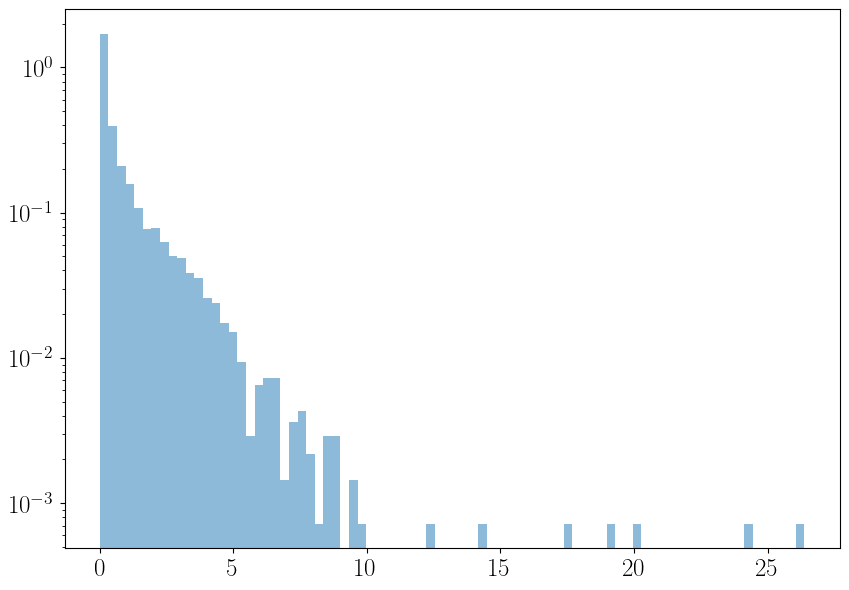

In [27]:
plt.figure()
plt.hist(data_hvs['A_G'], bins='scott', density=True, label='HVS', alpha=0.5)
plt.yscale('log')
plt.show()

In [28]:
# compute the completeness as a function of A_G limit
completeness = []
for ag in np.arange(0, 5, 0.1):
    data_ag = data_hvs.loc[data_hvs['A_G'] < ag]
    completeness.append(len(data_ag)/len(data_hvs))

In [29]:
# define an interpolator for the completeness
from scipy.interpolate import interp1d
completeness_interpolator = interp1d(np.arange(0, 5, 0.1), completeness)

# compute the completeness at 0.3 mag
sills_limit_completeness = completeness_interpolator(0.3)

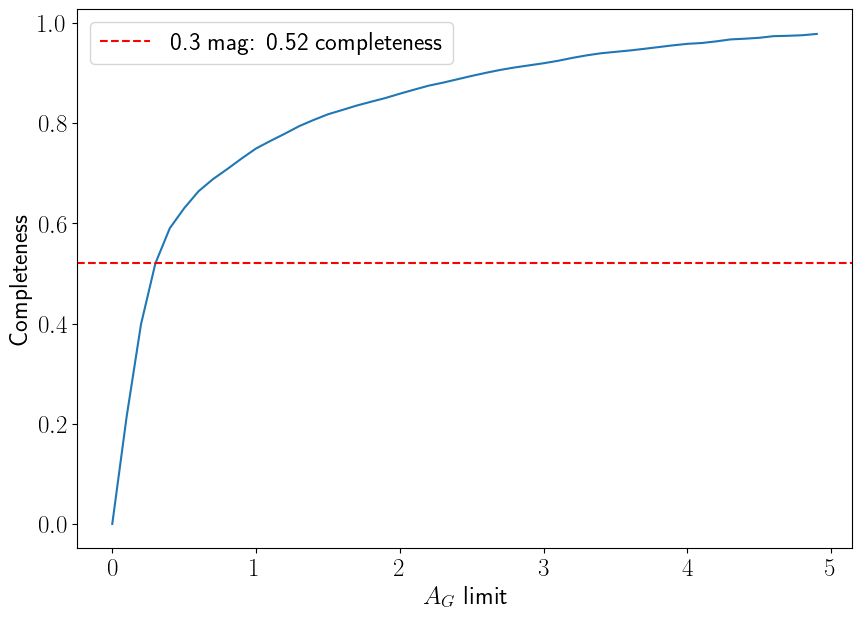

In [30]:
# plot the completeness
plt.figure()
plt.plot(np.arange(0, 5, 0.1), completeness)
plt.axhline(sills_limit_completeness, color='r', linestyle='--', label= f'0.3 mag: {sills_limit_completeness:.2f} completeness')
plt.xlabel(r'$A_G$ limit')
plt.ylabel('Completeness')
plt.legend()
plt.show()

In [78]:
completeness_interpolator(3)

array(0.91968431)

In [75]:
# create a limit interpolator function
limit_interpolator = interp1d(completeness, np.arange(0, 5, 0.1)) 

# compute the limit for 90% completeness
limit_90_completeness = limit_interpolator(0.95)
print(f'The 90% completeness limit is {limit_90_completeness:.2f} mag')

The 90% completeness limit is 3.74 mag


In [32]:
# make coordinates into galactic coordinates
from astropy.coordinates import SkyCoord

coords = SkyCoord(ra=data_hvs['ra'], dec=data_hvs['dec'], frame='icrs', unit='deg')
data_hvs['l'] = coords.galactic.l.deg
data_hvs['b'] = coords.galactic.b.deg

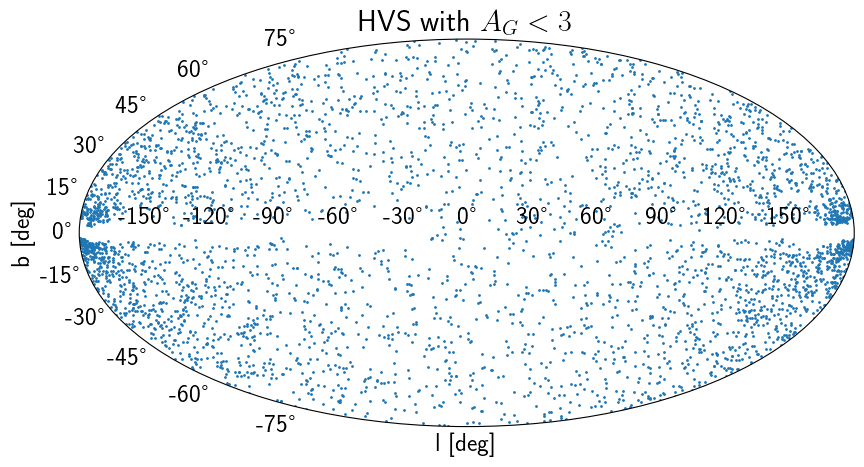

In [33]:
# plot the sky distribution of the HVS in  a mollwide plot
fig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'})

#ax.scatter(np.radians(data_hvs['ra'] - 180), np.radians(data_hvs['dec']), s=1)
# select only stars with A_G < 0.3
limit  = 3
data_ag = data_hvs.loc[data_hvs['A_G'] <  limit]
ax.scatter(np.radians(data_ag['l'] - 180), np.radians(data_ag['b']), s=1)
# plot galactic coordinates
#ax.scatter(np.radians(data_hvs['l'] - 180), np.radians(data_hvs['b']), s=1)
ax.set_xlabel('l [deg]')
ax.set_ylabel('b [deg]')
ax.set_title(f'HVS with $A_G <  {limit}$')
plt.show()


In [34]:
# plot selected stars in the sky next to a dustmap

import dustmaps.sfd
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

In [35]:
# construct all sky reddening map
l_range = np.arange(0, 365, 0.1)
b_range = np.arange(-90, 90, 0.1)
l, b = np.meshgrid(l_range,b_range )
coord_map = SkyCoord(l*u.deg, b*u.deg, distance = 100.*u.kpc, frame =  'galactic')

sfd = SFDQuery()
Av_sfd = 2.742 * sfd(coord_map)

In [36]:
Av_sfd_sim = 2.742 * sfd(coords)

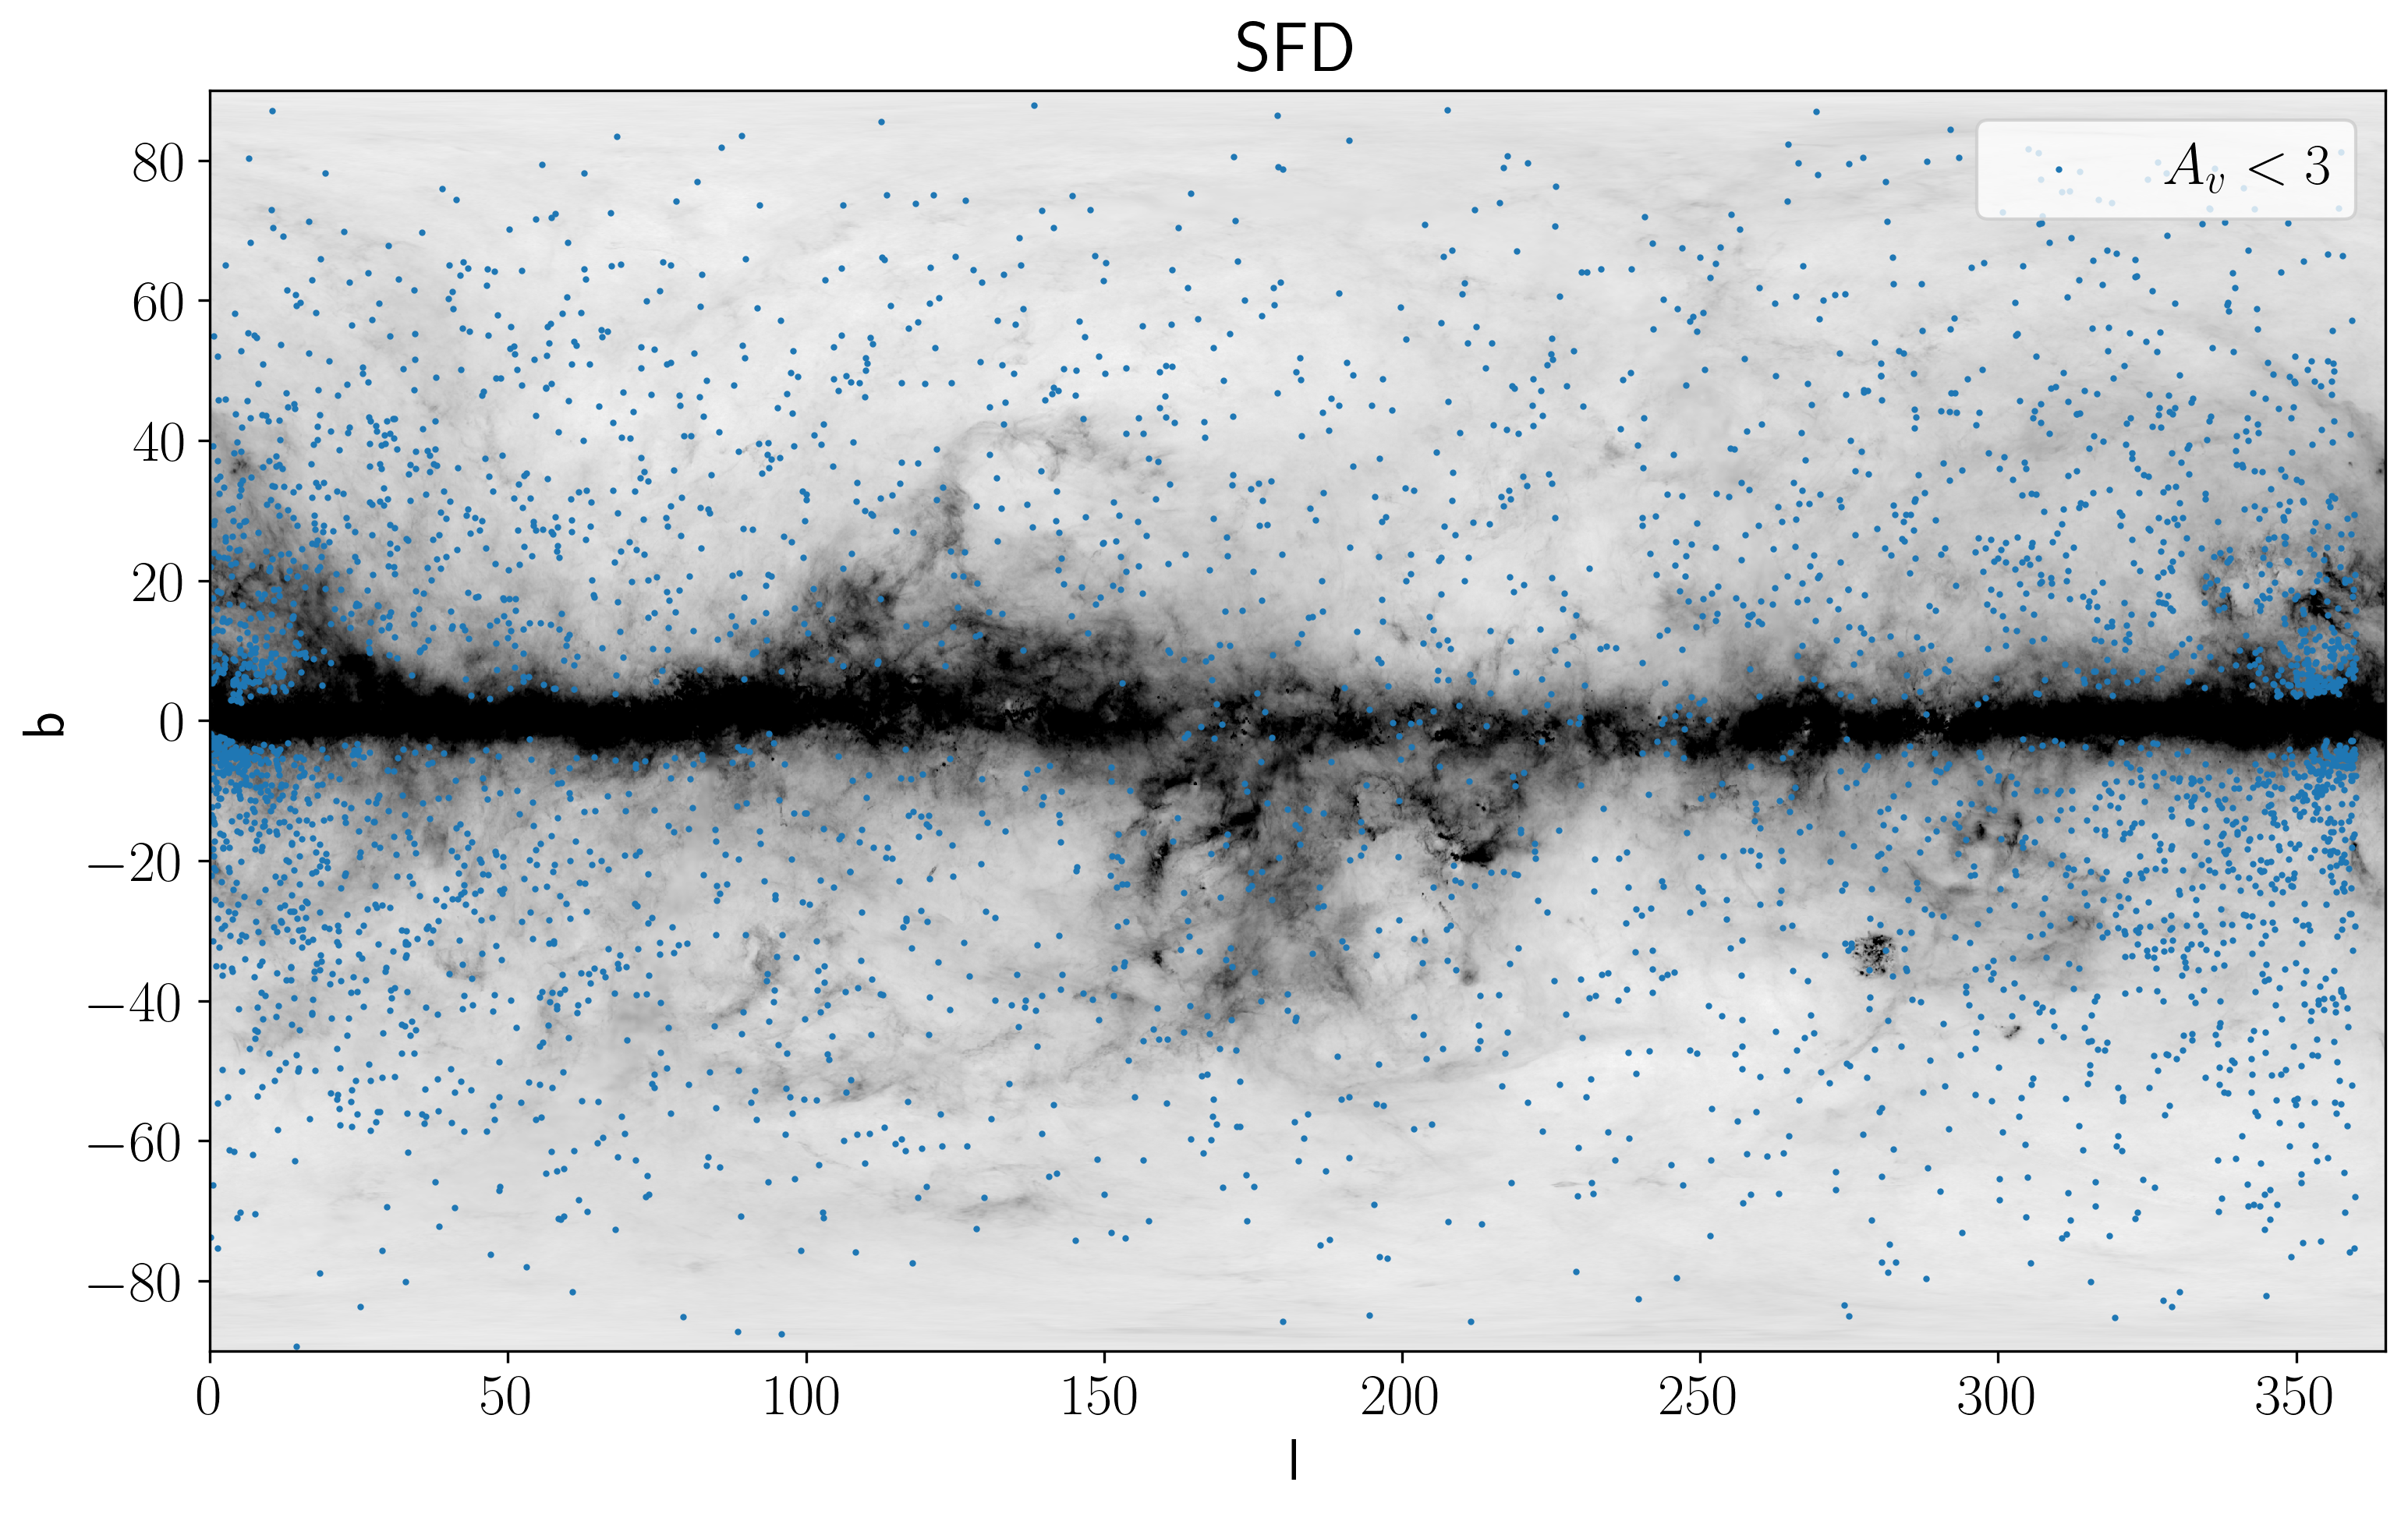

In [37]:
fig = plt.figure(figsize=(12,7), dpi=300)
ax = fig.add_subplot(111)
limit  = 3
data_ag = data_hvs.loc[data_hvs['A_G'] <  limit]
data_av = data_hvs.loc[Av_sfd_sim <  limit]
#plt.contour(l, b, Av_bayestar)
ax.pcolormesh(l, b, np.sqrt(Av_sfd), cmap = 'binary', shading = 'nearest', vmin=0., vmax=2.,)
#ax.scatter(data_ag['l']-180, data_ag['b'], s=1, alpha=1, label=f'$A_g < {limit}$')
ax.scatter(data_av['l'], data_av['b'], s=1, alpha=1, label=f'$A_v < {limit}$')
#ax.scatter(clu.l, clu.b, s= 14, c = 'y', label = 'Clustered')
plt.legend(loc = 'upper right')
plt.xlabel('l')
plt.ylabel('b')
plt.title('SFD')

#plt.savefig(os.path.join(plots_path, 'extincion_selection.png'), dpi = 600,  transparent=True)
plt.show()

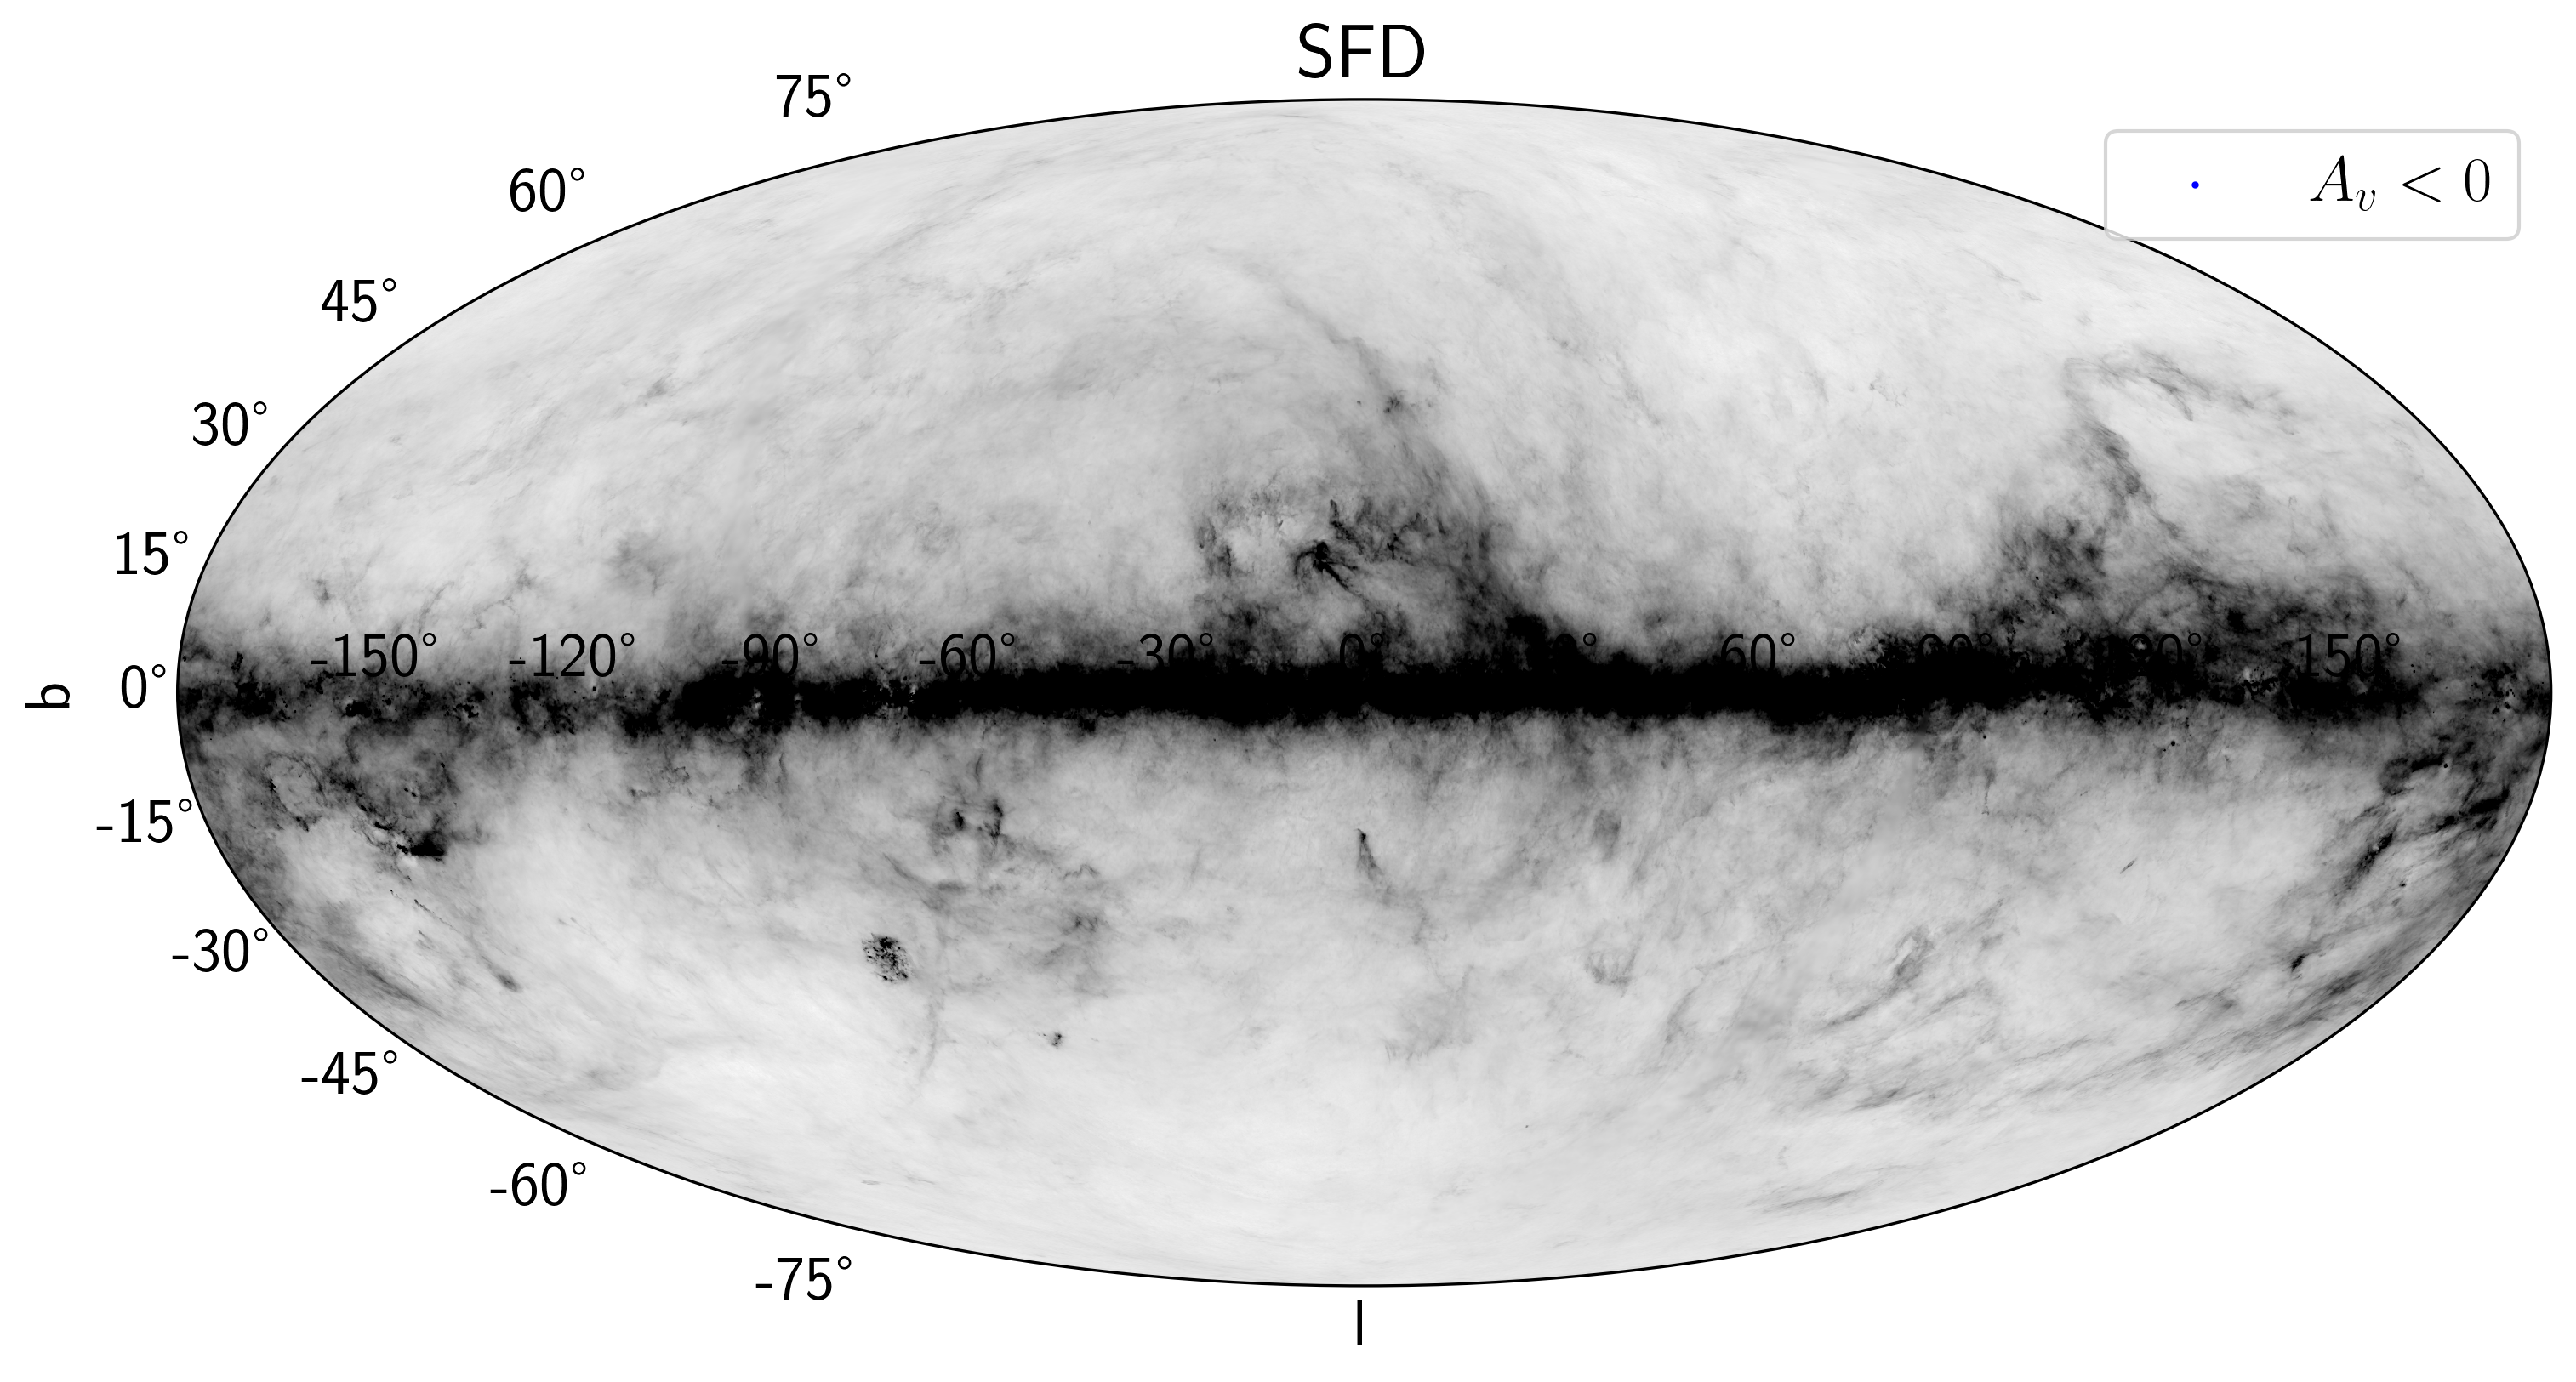

In [ ]:
# mollwide plot with colormesh
fig = plt.figure(figsize=(12,7), dpi=300)
ax = fig.add_subplot(111, projection = 'mollweide')
limit  = 3
data_ag = data_hvs.loc[data_hvs['A_G'] <  limit]
data_av = data_hvs.loc[Av_sfd_sim <  limit]
ax.pcolormesh(np.radians(l- 180) + np.pi , np.radians(b), np.sqrt(Av_sfd), cmap = 'binary', shading = 'nearest', vmin=0., vmax=2.,)
ax.pcolormesh(np.radians(l- 180) - np.pi , np.radians(b), np.sqrt(Av_sfd), cmap = 'binary', shading = 'nearest', vmin=0., vmax=2.,)

#ax.scatter(data_ag['l']-180, data_ag['b'], s=1, alpha=1, label=f'$A_g < {limit}$')
#ax.scatter(np.radians(data_av['l']), np.radians(data_av['b']), s=1, alpha=1, label=f'$A_v < {limit}$')

ax.scatter(np.radians(data_av['l']- 180) + np.pi, np.radians(data_av['b']), s=1, alpha=1, label=f'$A_v < {limit}$', c = 'blue')
ax.scatter(np.radians(data_av['l']- 180) - np.pi, np.radians(data_av['b']), s=1, alpha=1, c = 'blue')
#ax.scatter(clu.l, clu.b, s= 14, c = 'y', label = 'Clustered')
plt.legend(loc = 'upper right')
plt.xlabel('l')
plt.ylabel('b')
plt.title('SFD')
plt.show()

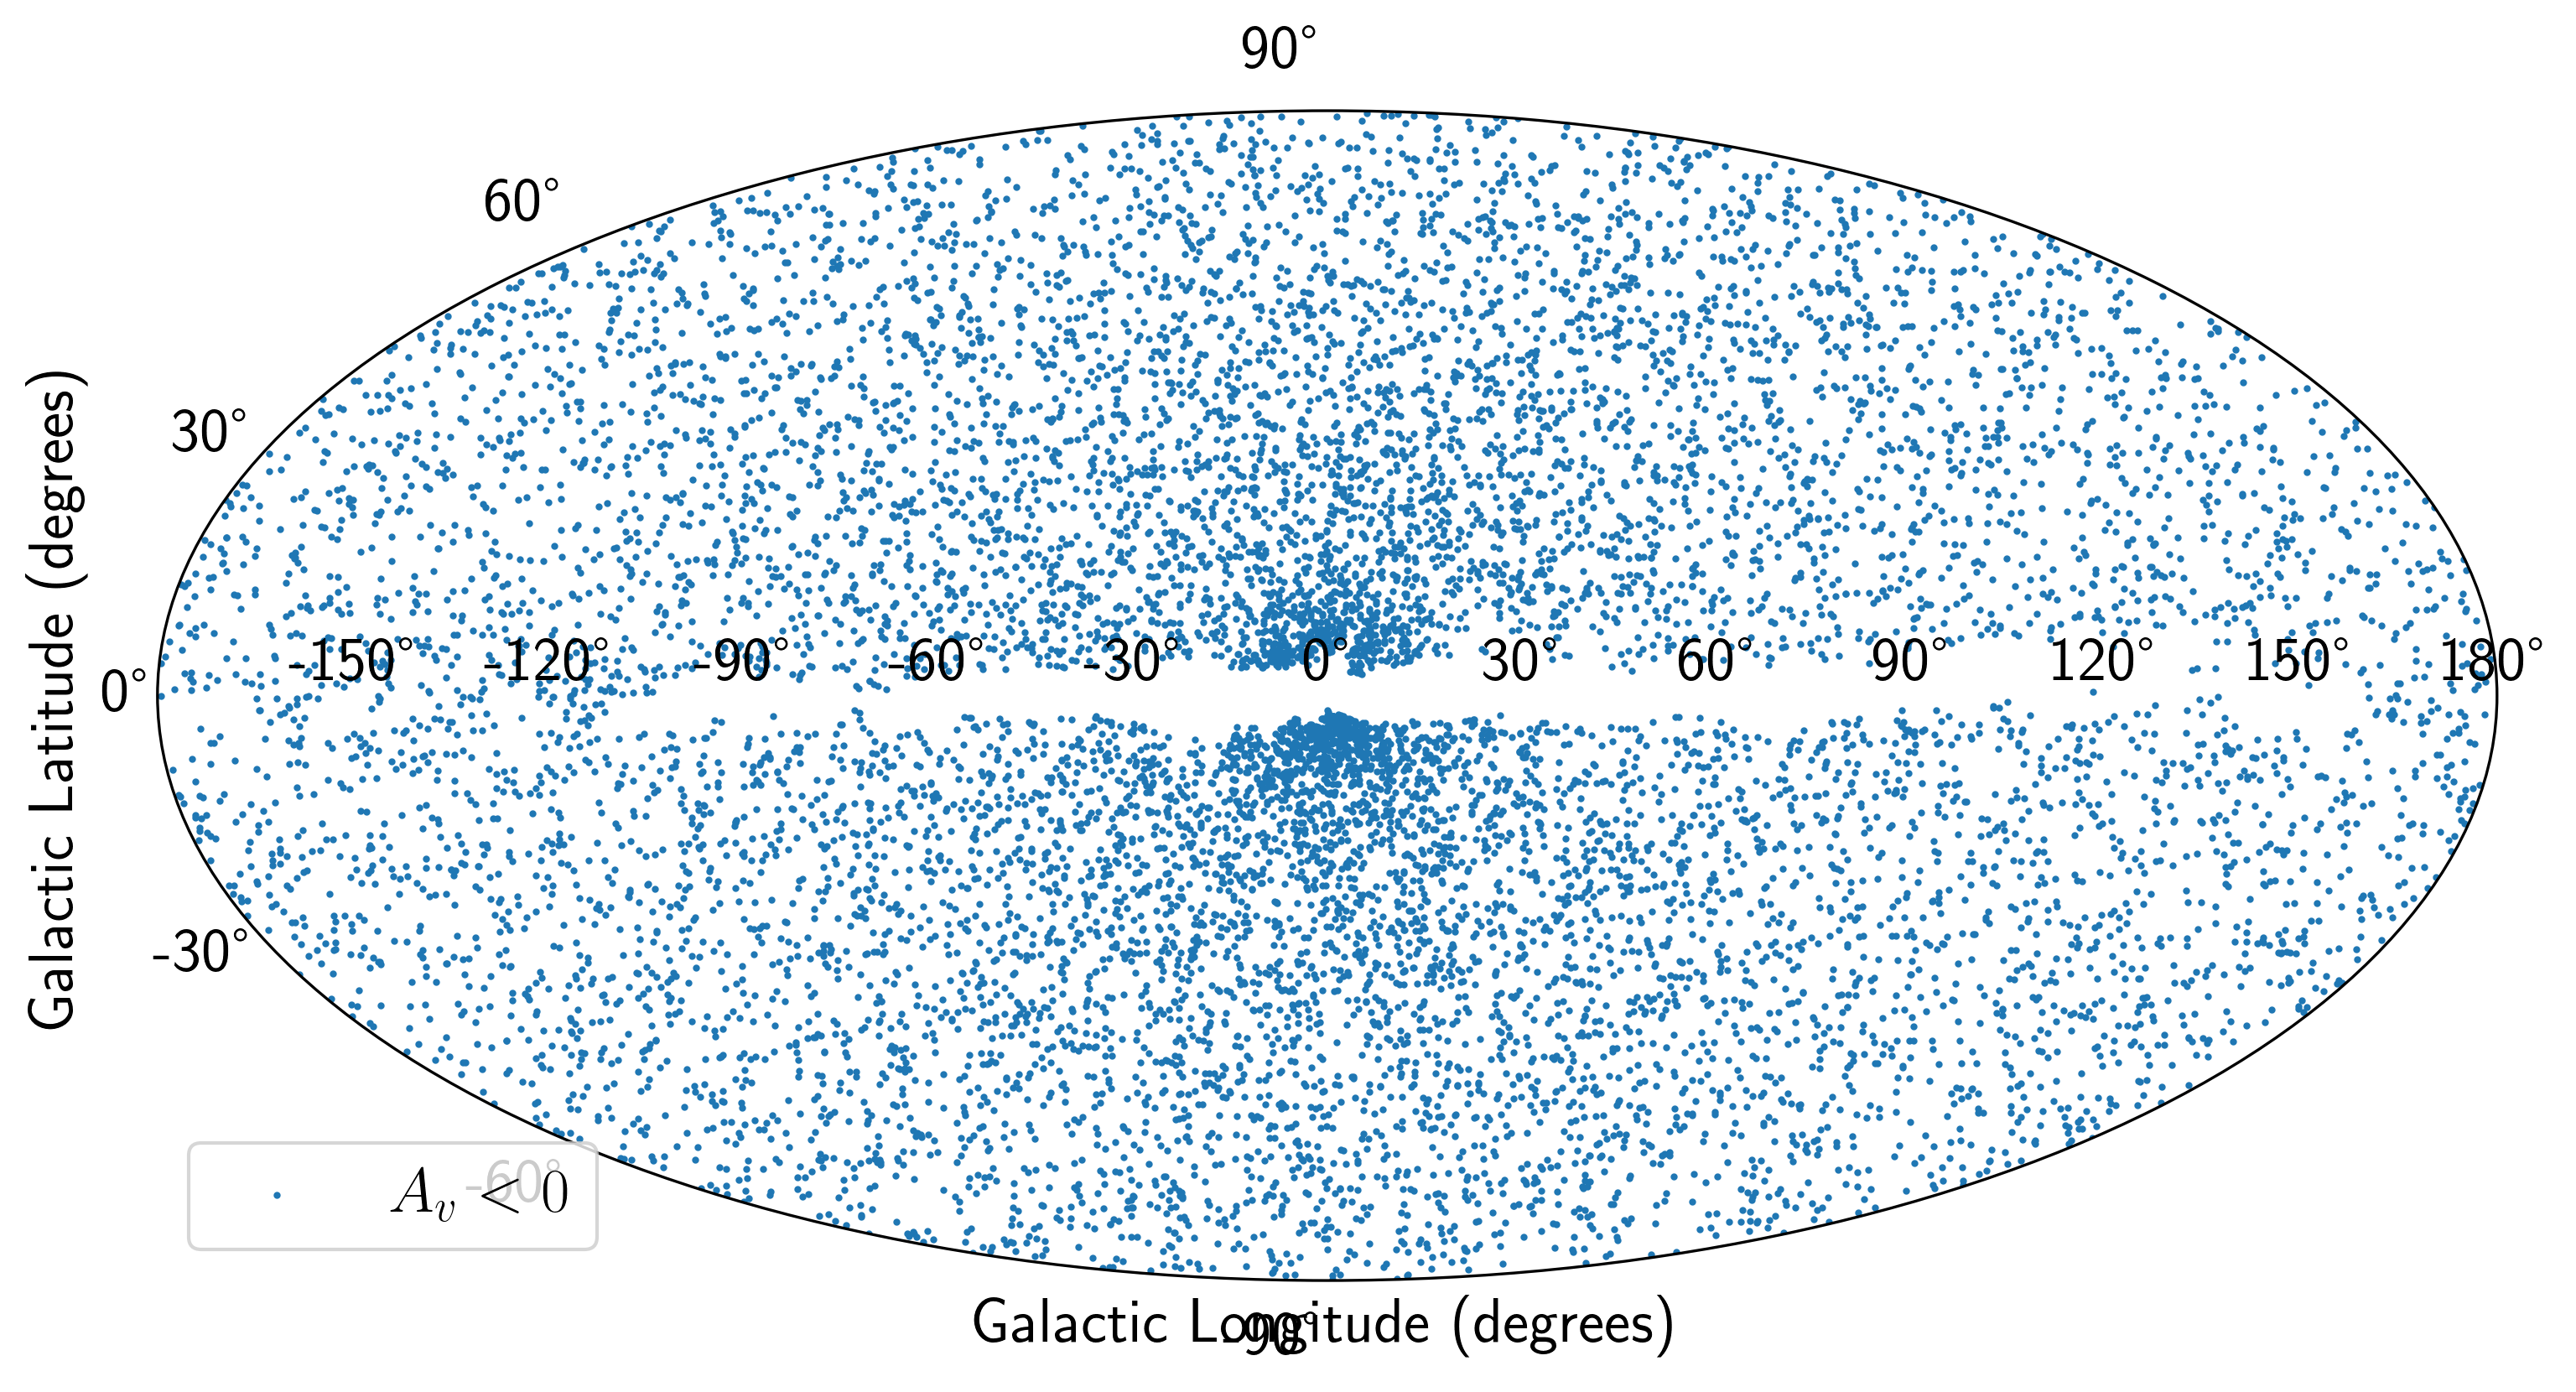

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure your longitude (l) and latitude (b) are in degrees
# Convert them to radians for the Mollweide projection
# Shift longitude from [0, 360] to [-180, 180] degrees to center l=0

# For grid data (background)
l_grid_deg = l  # Assuming 'l' is your grid longitude array in degrees
b_grid_deg = b  # Assuming 'b' is your grid latitude array in degrees

l_grid_deg_shifted = ((l_grid_deg + 180) % 360) - 180  # Shift to [-180, 180]
l_grid_rad = np.radians(l_grid_deg_shifted)
b_grid_rad = np.radians(b_grid_deg)

# For scatter data (data_av)
data_av_l_deg = data_av['l']
data_av_b_deg = data_av['b']

data_av_l_deg_shifted = ((data_av_l_deg + 180) % 360) - 180
data_av_l_rad = np.radians(data_av_l_deg_shifted)
data_av_b_rad = np.radians(data_av_b_deg)

# Create figure and axis with Mollweide projection
fig = plt.figure(figsize=(12, 7), dpi=300)
ax = fig.add_subplot(111, projection='mollweide')

limit = 0

# Plot the background data using pcolormesh
# Ensure l_grid_rad and b_grid_rad are 2D arrays matching Av_sfd dimensions
# If not, use np.meshgrid to create them
if l_grid_rad.ndim == 1 and b_grid_rad.ndim == 1:
    l_grid_rad_2d, b_grid_rad_2d = np.meshgrid(l_grid_rad, b_grid_rad)
else:
    l_grid_rad_2d = l_grid_rad
    b_grid_rad_2d = b_grid_rad

# pcolormesh_plot = ax.pcolormesh(
#     l_grid_rad_2d, b_grid_rad_2d, np.sqrt(Av_sfd),
#     cmap='binary', shading='nearest', vmin=0., vmax=2.,
# )

# Plot the scatter data
scatter_plot = ax.scatter(
    data_av_l_rad, data_av_b_rad, s=1, alpha=1, label=f'$A_v < {limit}$'
)

# Set labels and title
ax.set_xlabel('Galactic Longitude (degrees)')
ax.set_ylabel('Galactic Latitude (degrees)')
#ax.set_title('SFD Map Centered at Galactic Center')

# Adjust tick labels to show degrees instead of radians
xticks_deg = np.arange(-150, 181, 30)
xticks_rad = np.radians(xticks_deg)
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f'{int(tick)}°' for tick in xticks_deg])

yticks_deg = np.arange(-90, 91, 30)
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f'{int(tick)}°' for tick in yticks_deg])

# # Add a colorbar
# cbar = plt.colorbar(pcolormesh_plot, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label('Sqrt(Av_sfd)')

# Add legend
ax.legend(loc='lower left')

# Show the plot
#plt.tight_layout()
plt.show()
